In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

In [3]:
import altair as alt

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

# Load model

### User Input:
1. model_path - path to .pickle file of pretrained model
2. train_data_path - path to train data
3. test_data_path - path to test data
4. categorical_features - which features are categorical

In [4]:
model_path = 'loan_model.pickle'
X_train_data_path = 'loan_model_X_train_data.csv'
y_train_data_path = 'loan_model_y_train_data.csv'
X_test_data_path = 'loan_model_X_test_data.csv'
categorical_features = [0, 1, 2, 3, 4, 9, 10, 11]

---

In [5]:
import pickle

pickle_in = open(model_path,"rb")
model = pickle.load(pickle_in)
model

/anaconda3/envs/responsible_ds/lib/python3.6/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/envs/responsible_ds/lib/python3.6/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [6]:
X_train = pd.read_csv(X_train_data_path)
y_train = pd.read_csv(y_train_data_path)
X_test = pd.read_csv(X_test_data_path)

In [7]:
def model_prediction(x):
    return model.predict_proba(x)

# Skater (analyze model)

## Feature importance

2019-05-12 19:46:16,715 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[12/12] features ████████████████████ Time elapsed: 0 seconds

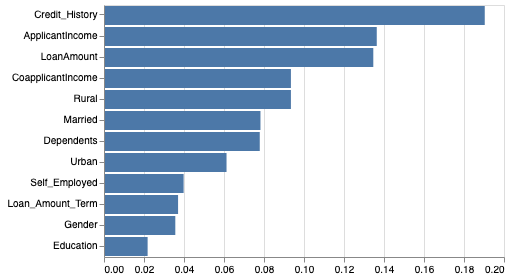

In [8]:
from src import feature_importance

feature_importance.analyze(model_prediction, X_train, render=True)

## Partial dependence 


2019-05-12 19:46:17,541 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[400/400] grid cells ████████████████████ Time elapsed: 11 seconds

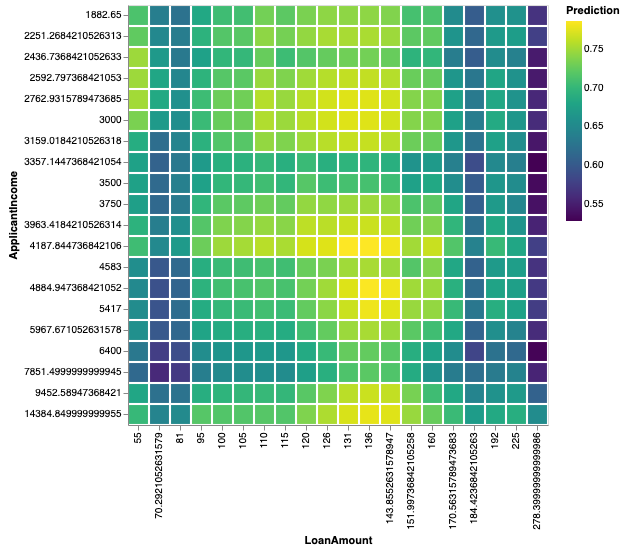

In [9]:
from src import partial_dependence

feature_1 = 'LoanAmount'
feature_2 = 'ApplicantIncome'

partial_dependence.analyze([feature_1, feature_2], model_prediction, X_train, render=True)

### TreeSurrogates (Experimental)

2019-05-12 19:46:28,862 - skater.core.global_interpretation.tree_surrogate - INFO - post pruning applied ...
2019-05-12 19:46:28,867 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used cross-entropy
2019-05-12 19:46:28,869 - skater.core.global_interpretation.tree_surrogate - INFO - original score using base model 9.992007221626413e-16
2019-05-12 19:46:29,002 - skater.core.global_interpretation.tree_surrogate - INFO - Summary: childrens of the following nodes are removed [5]
2019-05-12 19:46:29,004 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (384, 2)
2019-05-12 19:46:29,006 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.008; oracle score 0.134
2019-05-12 19:46:29,007 - skater.core.global_interpretation.tree_surrogate - WARNING - impurity score: 0.126 of the surrogate model is higher than the impurity threshold: 0.01. The higher the impurity score, lower 

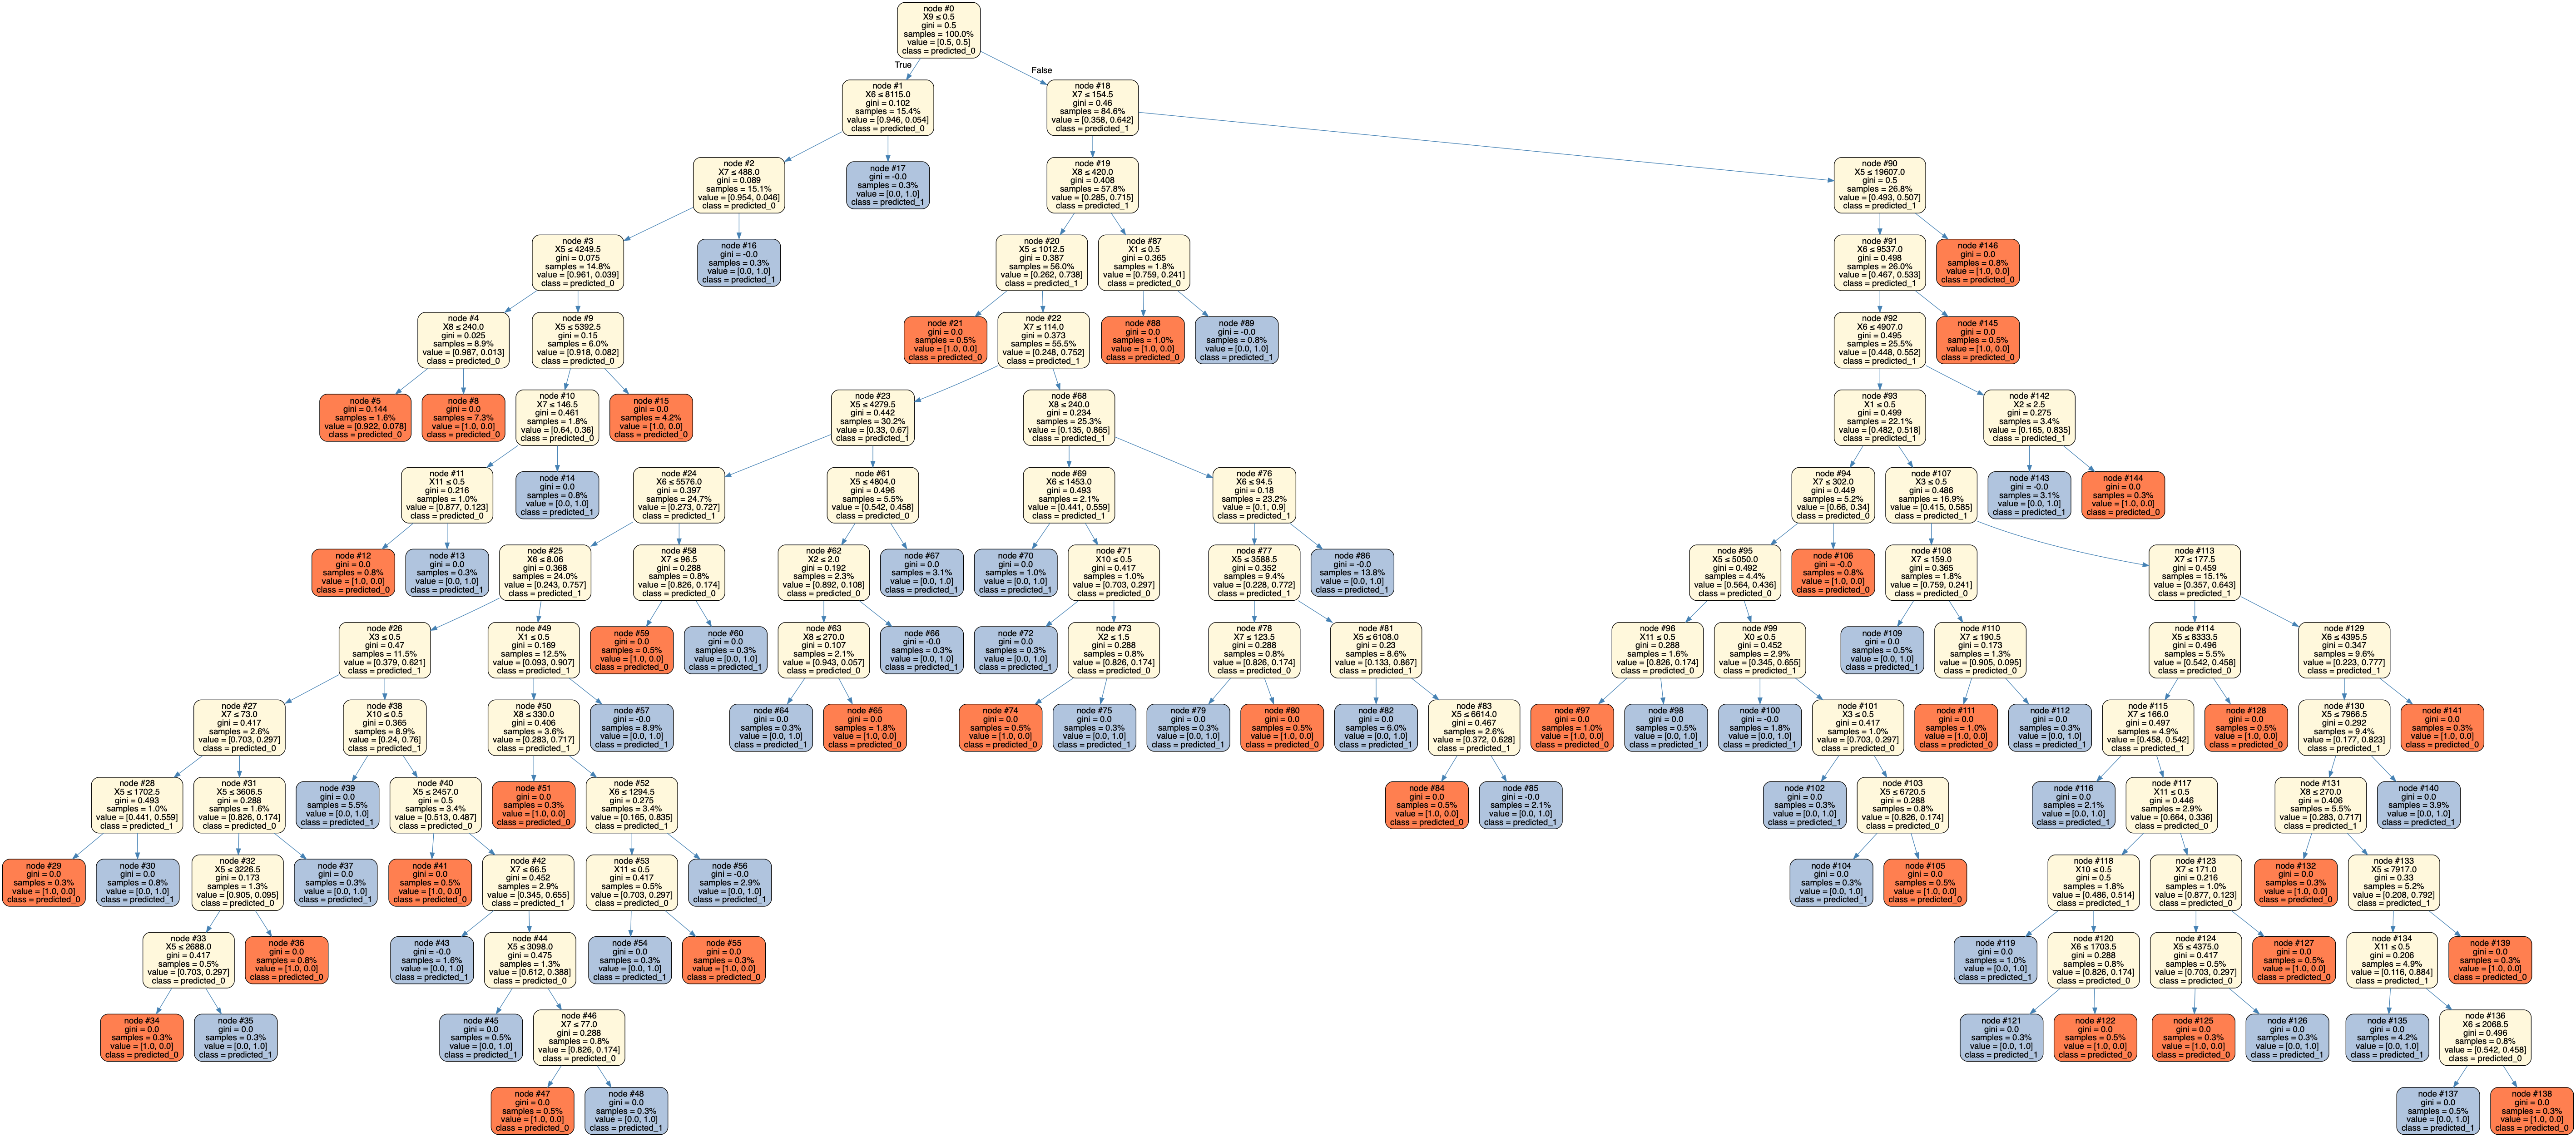

In [10]:
from src import tree_surrogate

tree_surrogate.analyze(model_prediction, X_train, y_train)

## LIME

In [11]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

In [12]:
from lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(X_train.to_numpy(), feature_names=list(X_train.columns))

In [13]:
exp = explainer.explain_instance(X_test.iloc[7, :], model_prediction, num_features=X_train.shape[1])
exp.show_in_notebook(show_table=True, show_all=False)

## Contrastive explanation
Based on https://arxiv.org/pdf/1806.07470.pdf and https://github.com/MarcelRobeer/ContrastiveExplanation

In [14]:
import src.contrastive_explanation as ce

dm = ce.domain_mappers.DomainMapperTabular(X_train.values, 
                                           feature_names = X_train.columns,
                                           categorical_features = categorical_features)

exp = ce.ContrastiveExplanation(dm)

### User Input:

- select test data indexes

In [15]:
indexes = [3, 6]

---

In [16]:
for i in indexes:
    sample = X_train.values[i]
    print('------')
    print(sample)
    print(exp.explain_instance_domain(model_prediction, sample))

------
[0.000e+00 1.000e+00 2.000e+00 1.000e+00 0.000e+00 2.708e+03 1.167e+03
 9.700e+01 3.600e+02 1.000e+00 0.000e+00 0.000e+00]
The model predicted '1' instead of '0' because 'ApplicantIncome > 1489.133'
------
[0.00e+00 1.00e+00 1.00e+00 1.00e+00 0.00e+00 6.40e+03 7.25e+03 1.80e+02
 3.60e+02 0.00e+00 1.00e+00 0.00e+00]
The model predicted '0' instead of '1' because 'not Credit_History and Loan_Amount_Term <= 420.531 and Married and LoanAmount <= 233.884'


# Prototypes and Criticisms 

In [17]:
from src import mmd
mmd = mmd.MMD(X_train.values, y_train.values.reshape(1, -1)[0])

In [18]:
num_prototypes = 5
num_criticisms = 5
p_indices, c_indices = mmd.acquire_prototypes_and_criticisms_idx(num_prototypes, num_criticisms)

Top 5 potential prototypes

In [19]:
pd.DataFrame(X_train, index=p_indices)

Gender  Married  Dependents  Education  Self_Employed  ApplicantIncome  \
317       0        1           1          1              1             3450   
337       1        0           0          1              0             2400   
233       0        1           1          1              0             1625   
300       0        0           0          0              0             3975   
362       0        0           0          0              0             3902   

     CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  Urban  \
317             2079.0       162.0             360.0             1.0      0   
337             1863.0       104.0             360.0             0.0      1   
233             1803.0        96.0             360.0             1.0      1   
300             2531.0        55.0             360.0             1.0      0   
362             1666.0       109.0             360.0             1.0      0   

     Rural  
317      0  
337      0  
233      0  
300      1  
362      1

Top 5 potential criticisms

In [20]:
pd.DataFrame(X_train, index=c_indices)

Gender  Married  Dependents  Education  Self_Employed  ApplicantIncome  \
91        0        1           3          1              0             3430   
51        0        1           0          1              0             3033   
105       0        1           2          1              1            16525   
13        0        1           2          0              0             3357   
73        1        0           0          1              0             5000   

     CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  Urban  \
91              1250.0       128.0             360.0             0.0      0   
51              1459.0        95.0             360.0             1.0      1   
105             1014.0       150.0             360.0             1.0      0   
13              2859.0       144.0             360.0             1.0      1   
73                 0.0       103.0             360.0             0.0      0   

     Rural  
91       0  
51       0  
105      1  
13       0  
73       0